# Tutorial 3: Cholesky method

In [1]:
# Load packages:

# this package allows to work efficiently with arrays
import numpy as np
# this package is used to draw graphs
import matplotlib.pyplot as plt
# for the numerical application in the end, we will use pi
from math import pi

---

## Historical background
André-Louis Cholesky (1875-1918), student at the école polytechnique (X1895), originally designed his method for solving linear problems for a problem emerging in the field of topography. He worked on triangulations to draw maps of different countries. 

A triangulation is of a set of triangles covering the domain to be mapped. To each node of this triangulation is associated its position and its altitude, which are required to draw the map. On the field, only distances and angles can be evaluated, the positions and the altitudes need to be computed based on these observations. One verifies that, using only the length of one side of a triangle and two of its angles, one may reconstruct all the others. To simplify, assuming that the lengths and angles are linear functions of positions and altitude, one rewrites this problem under the form 

$$A V = b$$

where $b$ is a vector of the lengths and angles observed, $A$ is a matrix, and $V$ is the vector of the exact positions and altitudes of the nodes that we seek.  
 
However, in practice, the evaluations of lengths and angles can be inexact due to human or instrument inaccuracy. Thus, more evaluations are performed, e.g. evaluating all the angles and the lengths of all sides of a triangle. In the new problem $AV=b$, we have more data $b\in\mathbb{R}^M$ than unknowns $V\in\mathbb{R}^N$, i.e. $M>N$ and the matrix $A\in\mathbb{R}^{M \times N}$ is rectangular. This problem does not have a solution in general (only if all observations agrees exactly with each others). Instead, we minimize the error $\epsilon(V) = \|A V - b\|_2^2$, which has a solution. This solution satisfies the so-called normal equation 

$$ A^T A V = A^T b. $$

We discuss here numerical solution of this new linear equation.


---

## Preliminary computations

1) Prove that $B = A^T A$ is square, symmetric and positive. Give a condition on the columns $C^{j}$ (s.t. $C_i^j = A_{i,j}$) for $B$ to be definite (this will be assumed in the next questions).

**Answer:**

As $A$ is an $M\times N$ matrix, $A^T$ is $N\times M$ and $A^T\times A$ is $N\times N$. Moreover, $(A^T A)^T = A^T(A^T)^T = A^T A$, so $A^TA$ is symmetric.
Let $V\in\mathbb{R}^N$. $V^TBV = \|AV\|_2^2\geq 0$, thus $B$ is positive.


Suppose that the columns $(C_j)_j$ of $A$ are linearly independent. Then for any $V\in \mathbb{R}^N$, $A V = \sum_{j=1}^N V_j C_j$ vanishes if and only if $V=0$. As a result, $V^T A^T A V = \|AV\|_2^2$ vanishes only if $V=0$, thus $B$ is definite.


2) Here, we consider that $A$ is square and $A^T A$ is definite. Prove that $A$ is invertible and that the problems $A V = b$ and $(A^T A) V = A^T b$ have the same solution $V$.

**Answer:**

 If $A$ is square, then $det(A)$ is well defined and $det(A^TA) = det(A)^2$. $A$ is thus invertible. In particular, let $U,V\in\mathbb{R}^N$ be two vectors such that, respectively, $AU=b$ and $BV=A^Tb$. Then $A^T A U = A^T b$. As $B = A^T A$ is definite, it is injective and $BU = BV$ implies $U=V$: the solution of both problems is the same.

3) Suppose that $AA^T$ is definite and write $\bar{V} = (AA^T)^{-1} A^T b$ the solution of the normal equation. Prove that $\bar{V}$ minimizes the error $\epsilon(V) = \|AV-b\|_2^2$. 

*Hints*: Consider any perturbation $\bar{V} + \delta$ and show that $\| A(\bar{V}+\delta) -b \|_2^2 \ge \| A\bar{V} -b \|_2^2$. (Remark also that $\|V\|_2^2 = V^T V$).

**Answer:**

Writing 

\begin{align*} 
    \epsilon(V+\delta) &= \left(A(V+\delta) - b\right)^T \left(A(V+\delta) - b\right) \\
    &= (V+\delta)^T A^T A (V+\delta) - b^T A (V+\delta) - (V+\delta)^T A^T b + b^T b \\
    &= \epsilon(V) + \delta^T A^T A \delta + \delta^T A^T A V + V^T A^T A \delta - b^T A \delta - \delta^T A^T b\\
    &= \epsilon(V) + \delta^T A^T A \delta + 2 (A^T A V - A^T b)^T \delta \\
    &= \epsilon(V) + \delta^T A^T A \delta
\end{align*}

where the second term is strictly positive for non zero $\delta$.

---

## First decomposition

*Remark:* This tutorial exploits diagonal and triangular matrices. In the implementation part, all these matrices are constructed and stored entirely, even if most of their coefficients are zero. Such an implementation can easily be improved in order not to store trivial values. The discussion on the storage of such matrices is postponed to a future tutorial.

4) Cholesky remarked that if $A^T$ was square and lower triangular, then solving $A^T A V = A^T V$ could be performed in two parts very easily (and accessible with the technology of its time). Then, he suggested decomposing any symmetric positive definite $B$ as the product of a lower triangular matrix and its transposed $B = L L^T$. 

a) Write down the coefficients $(L L^T)_{i,j}$ as a function of the coefficient $L_{i,j}$. 

b) Write the diagonal coefficient $L_{i,i}$ as a function of $B_{i,i}$ and of $L_{i,j}$ with $j<i$ 

*Hints*: Represent on paper the matrix $L$. 

c) Write the non-diagonal coefficient $L_{j,i}$ with $j<i$ as a function of $B$ and of the relevant coefficients of $L$. 

**Answer:**

a) $$(LL^T)_{i,j} = \sum_{k=1}^N L_{i,k}L^T_{k,j} = \sum_{k=1}^N L_{i,k}L_{j,k}.$$ As $L$ is lower triangular, $L_{a,b} =0$ if $a<b$. The previous sums thus reduces to: $$(LL^T)_{i,j} = \sum_{k=1}^{min(i,j)} L_{i,k}L_{j,k}.$$

b) In particular if $i=j$, $$B_{i,i} = (LL^T)_{i,i} = \sum_{k=1}^i L_{i,k}^2,$$ so that:
$$L_{i,i} = \sqrt{B_{i,i} - \sum_{k=1}^{i-1}L_{i,k}^2}. $$

c) Similarly, $$B_{i,j} = \sum_{k=1}^j L_{i,k}L_{j,k}$$ yields $$L_{i,j} = \frac{B_{i,j} - \sum_{k=1}^{j-1} L_{i,k}L_{j,k}}{L_{j,j}}.$$

5) Doing the computations in the appropriate order, write an algorithm for the computation of all the entries of $L$. 
Explain your choice for doing the computations in this order.

**Answer:**

To compute $L_{i,i}$, we need to know how the coefficients of line $i$. To compute these coefficients, i.e. the $L_{i,j}$ with $j<i$, we need to know the previous coefficients of line $i$, i.e. the $L_{i,k}$ for $k<j$; as well as the $L_{j,j}$. The algorithm can thus compute coefficients line by line, and in each line go from left to right to make sure that only already known coefficients of $L$ enter in the computation of the next one. Another possibility would be to compute each column one after other, from left to right.

6) a) For the test below, we use the following matrix 

$$ B = \left( \begin{array}{ccc} 1 & 2 & 3 \\ 2 & 5 & 10 \\ 3 & 10 & 26 \end{array} \right).$$

Compute its Cholesky decomposition if possible.

b) Using 5), propose and implement an algorithm to compute a lower triangular matrix $L \in\mathbb{R}^{N \times N}$ such that $L L^T = B$ for any symmetric positive definite matrix $B$. 

c) Test your algorithm with the matrix in 6)a) and compare the result obtained. 

d) Test it also with the larger matrix $B\in\mathbb{R}^{N\times N}$ defined such that 

$$ B_{i,j} = 1 + 2N \delta_{i,j} $$ 

for $N=10$. Verify that the obtained matrix satisfies $B=LL^T$ as expected.

**Answer:**

a) $B = L L^T$ with 

$$ L = \left( \begin{array}{ccc} 1 & 0 & 0 \\ 2 & 1 & 0 \\ 3 & 4 & 1 \end{array}\right).$$

In [2]:
# b)
def Cholesky_decomp(B):
    """
    Compute the Cholesky decomposition of a symmetric positive definite matrix
    ----------   
    parameters:
    B : symmetric positive definite matrix (numpy array of size N,N)
        
    returns:
    L : lower triangular matrix (numpy array of size N,N) such that L L^T = B
    """
    
    N = len(B[0,:])
    L = np.eye(N)
    
    for i in range(N):
        for j in range(i):
            L[i,j] = (B[i,j] - np.sum([L[i,k]*L[j,k] for k in range(j)])) / L[j,j]
        L[i,i] = np.sqrt(B[i,i] - np.sum([L[i,k]*L[i,k] for k in range(i)]))           
    
    return L

In [26]:
# c) Test 1: 
B = np.array([[1,1,1],[2,3,1],[4,5,6]])
# implement your test here

print("Matrix:\n", B,"\n")
print("Cholesky decomposition:\n", Cholesky_decomp(B))

Matrix:
 [[1 1 1]
 [2 3 1]
 [4 5 6]] 

Cholesky decomposition:
 [[ 1.  0.  0.]
 [ 2. nan  0.]
 [ 4. nan nan]]


/var/folders/rf/3_96g3x522q394xqlyg__5l00000gn/T/ipykernel_99706/2435010302.py:19: RuntimeWarning: invalid value encountered in sqrt
  L[i,i] = np.sqrt(B[i,i] - np.sum([L[i,k]*L[i,k] for k in range(i)]))


In [4]:
# d) Test 2: 
N = 10
B = np.ones(N) + 2*N*np.eye(N)

print("Matrix:\n", B,"\n")
print("Cholesky decomposition:\n", Cholesky_decomp(B))

Matrix:
 [[21.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. 21.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. 21.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1. 21.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1. 21.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1. 21.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1. 21.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1. 21.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1. 21.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1. 21.]] 

Cholesky decomposition:
 [[4.58257569 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.21821789 4.57737708 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.21821789 0.20806259 4.57264594 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.21821789 0.20806259 0.19881069 4.56832193 0.         0.
  0.         0.         0.         0.        ]
 [0.21821789 0.20806259 0.19881069 0.19034675 4.56435465 0.
  0.         0.         0.         0.        

---

## Second decomposition

Now, we modify this algorithm such that it works with symmetric matrices that are not necessarily positive definite. In practice, we seek a $L D L^T$ decomposition where $L$ is still lower triangular, it has only ones on the diagonal, and $D$ is a diagonal matrix (not necessarily positive). 

7) Based on the construction in 4), propose an algorithm that computes $L$ and $D$ for a symmetric matrix $B = L D L^T$. Explain the choice of the order in which you perform all the operations.

**Answer:**

The matrix $LDL^T$ has entry $i,j$ given by: 
$$ (LDL^T)_{i,j} = \sum_{k=1}^N L_{i,k} d_kL_{j,k} = \sum_{k=1}^{\min(i,j)} L_{i,k}d_k L_{j,k},$$ 
where $d_k := D_{k,k}$. 
Here all diagonal coefficients of $L$ are fixed to 1, and it is those of $D$ that will play the role. More precisely, for $i=j=1$ one obtains $d_1 = B_{1,1}$. With this it is possible to get $L_{2,1}$: $$L_{2,1} = \frac{B_{2,1}}{L_{1,1}d_1} = \frac{B_{2,1}}{d_1}$$ provided $d_1\neq 0$. $L_{2,1}$ enables one to get $d_2$, and one can compute coefficients line by line as before. To change a bit, we do it one column after the other instead.

8) a) In the test below, we use the following matrix 

$$ B = \left( \begin{array}{ccc} 1 & 2 & 3 \\ 2 & 2 & -2 \\ 3 & -2 & -20 \end{array} \right). $$

Compute its $LDL^T$ decomposition if possible. 

b) Using 6) and 7), implement an algorithm to compute a lower triangular matrix $L \in\mathbb{R}^{N\times N}$ and a diagonal matrix $D \in \mathbb{R}^{N \times N}$ such that $L D L^T = B$ for any symmetric matrix 𝐵.

c) Test your algorithm with the matrix in 6)a) and 8)a) and compare the result obtained. 

d) Test it again with the matrix in 6)d) and verify that the matrices you obtain satisfy $LDL^T = B$ as expected. 

**Answer:** 

a) $B = LDL^T$ with 

$$ L = \left( \begin{array}{ccc} 1 & 0 & 0 \\ 2 & 1 & 0 \\ 3 & 4 & 1 \end{array}\right), \qquad D = Diag(1,-2,3)$$

In [5]:
# b)
def LDL_decomp(B):
    """
    Compute the L D L^T decomposition of a symmetric matrix
    ----------   
    parameters:
    B : symmetric matrix (numpy array of size N,N)
        
    returns:
    L : lower triangular matrix (numpy array of size N,N) such that L D L^T = B
    D : diagonal matrix (numpy array of size N,N) such that L D L^T = B
    """

    N = len(B[0,:])
    
    L = np.eye(N)
    D = np.eye(N)
    
    for j in range(N):
        D[j,j] = B[j,j] - np.sum([D[k,k]*L[j,k]**2 for k in range(j)])
        for i in range(j+1, N):
            L[i,j] = (B[i,j] - np.sum([D[k,k]*L[i,k]*L[j,k] for k in range(j)])) / D[j,j]

    return L, D

In [6]:
# c) Test 1: 
B = np.array([[1,2,3],[2,2,-2],[3,-2,-20]])

L, D = LDL_decomp(B)
print("Matrix:\n", B,"\n")
print("Cholesky decomposition:\n L =\n", L, "\n\nD=\n", D)

Matrix:
 [[  1   2   3]
 [  2   2  -2]
 [  3  -2 -20]] 

Cholesky decomposition:
 L =
 [[1. 0. 0.]
 [2. 1. 0.]
 [3. 4. 1.]] 

D=
 [[ 1.  0.  0.]
 [ 0. -2.  0.]
 [ 0.  0.  3.]]


In [7]:
# c) Test 1: 
B = np.array([[1,2,3],[2,5,10],[3,10,26]])

L, D = LDL_decomp(B)
print("Matrix:\n", B,"\n")
print("Cholesky decomposition:\n L =\n", L, "\n\nD=\n", D)

Matrix:
 [[ 1  2  3]
 [ 2  5 10]
 [ 3 10 26]] 

Cholesky decomposition:
 L =
 [[1. 0. 0.]
 [2. 1. 0.]
 [3. 4. 1.]] 

D=
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [8]:
# d) Test 2:  
N = 10
B = np.ones(N) + 2*N*np.eye(N)

L, D = LDL_decomp(B) 
print("Matrix:\n", B,"\n")
print("LDL^T decomposition:\nL=\n",L,"\n\nD=\n",D)

Matrix:
 [[21.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. 21.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. 21.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1. 21.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1. 21.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1. 21.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1. 21.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1. 21.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1. 21.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1. 21.]] 

LDL^T decomposition:
L=
 [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.04761905 1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.04761905 0.04545455 1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.04761905 0.04545455 0.04347826 1.         0.         0.
  0.         0.         0.         0.        ]
 [0.04761905 0.04545455 0.04347826 0.04166667 1.         0.
  0.         0.         0.         0.        

9) Consider a symmetric positive definite matrix $B$ and its two decompositions 

$$ L^1 (L^1)^T = B = L^2 D (L^2)^T. $$

How can you relate $L^1$ from the Cholesky decomposition to $L^2$ and $D$ from the $LDL^T$ decomposition ?  Express one as a function of the others.

**Answer:**

If $B$ is positive definite, then $D$ must be positive definite as well. 
Indeed, assume that there is a vector $V\in\mathbb{R}^N$ with $V^TDV \leq 0$. Then as $L^2$ is invertible, there is $U\in\mathbb{R}^N$ with $(L^2)^T U = V$. But then $0\leq U^TBU = V^T D V \leq 0$, which means equality holds everywhere and $V=0$.

As a result, the matrix $\sqrt{D} = (\sqrt{D_{i,j}})_{i,j}$ is well-defined, and one can simply write $L^1 = L^2\sqrt{D}$. 

Since $LL^T$ and $LDL^T$ decompositions of a given matrix are unique, this is the only way of relating $L^1$ and $L^2$.

10) a) Compare the number of operations required to compute $L^1 (L^1)^T$ and $L^2 D (L^2)^T$ decompositions (square root is counted as one operation). 

b) Compare the number of non-zero entries of $L^1$ and of $D$ and $L^2$ that you need to construct these matrices.

**Answer:**

a) For $L^2D(L^2)^T$, the computation of $D^2_{j,j}$ requires 2 multiplications for each of the $j$ terms of the sum, plus one subtraction, thus $2j+1$ in total. 

Computing $L^2_{i,j}$ for $i>j$ requires as many operations as computing $L^1_{i,j}$ for $i>j$, i.e. 2 mltiplications for each of the $j-1$ terms in the sum, one subtraction and one division, i.e. $2j$ in all (not taking into account the order in which operations are made should it change anything).

For $L^1_{i,i}$, again 2 multiplications for each of the $j$ terms of the sum are used, then one subtraction, and a square root, for a total of 2j+2. The difference between the two methods is thus of the order of the size $N$ of the matrix, which is much less than the total number of operations (roughly $N^3$).

b) The number of non-trivial entries is the same.

---

## Application to least square problem and curve fitting

As in the introduction, suppose now that we try to approach a parametrized curve using data points, such that we have more data than parameters. We aim to construct a curve of the form 

$$ f(x) = \exp\left(\sum\limits_{i=0}^{N-1} V_i x^i\right) $$

passing as close as possible to the data $(y_j)_{j=0,\dots,M}$ at the positions $(x_j)_{j=1,\dots,M}$. 
In practice, we seek the coefficients $(V_i)_{i=0,\dots,N-1}$. 

11) a) Write an equation equivalent to 

$$\exp\left(\sum\limits_{i=0}^{N-1} V_i x_j^i\right) = y_j$$

where the left-hand-side is a linear function of the $V_i$. 

b) Then, write this problem as linear problem $A V = c$ with a non-square matrix $A$. Especially, write down the entries of $A$ and $c$ based on the points $(x_i,y_i)_{i=1,\dots,N}$. 

Since this matrix $A$ is non square, we will use 3) to find the parameters $(V)_{i=0,\dots,N-1}$ that minimize $\|AV -b\|_2^2$. 

**Answer:**

a) $$\sum\limits_{i=0}^{N-1} V_i x_j^i = \log y_i$$

b) $$A_{i,j} = x_j^i, \qquad c_i = \log y_i$$


12) a) For the test in the next question, we will use the matrix 

$$ A = \left( \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ 5 & 6 \end{array}\right).$$

Compute $B = A^T A$, the Cholesky decomposition of $B$ and the $LDL^T$ of $B$.

b) Implement an algorithm that takes an *a priori* non-square matrix $A$ and apply either the algorithm from 6) or from 8) to compute the Cholesky or the $LDL^T$ decomposition of the matrix $A^T A$.

c) Test it with the matrix $A$ given in 12)a) and compare results obtained.  

**Answer:**

a) $$A^T A = \left(\begin{array}{cc} 35 & 44 \\ 44 & 56 \end{array}\right), \qquad\qquad L_{cholesky} = \left(\begin{array}{cc} \sqrt{35} & 0 \\ \frac{44}{\sqrt{35}} &  \sqrt{\frac{24}{35}}\end{array}\right), \qquad\qquad L_{LDL^T} = \left( \begin{array}{cc} 1 & 0 \\ \frac{44}{35} & 1 \end{array} \right),\qquad D_{LDL^T} = Diag(35,\frac{24}{35}) $$

In [9]:
# b)
def Cholesky_decomp_non_sq(A):
    """
    Compute the Cholesky decomposition of A A^T
    ----------   
    parameters:
    A : non square matrix (numpy array of size N,M)
        
    returns:
    L : lower triangular matrix (numpy array of size N,N) such that L L^T = A A^T
    """
    return Cholesky_decomp(np.matmul(np.transpose(A),A))

In [10]:
def LDL_decomp_non_sq(A):
    """
    Compute the L D L^T decomposition of A A^T
    ----------   
    parameters:
    A : non square matrix (numpy array of size N,M)
        
    returns:
    L : lower triangular matrix (numpy array of size N,N) such that L D L^T = A A^T
    D : diagonal matrix (numpy array of size N,N) such that L D L^T = A A^T
    """    
    return LDL_decomp(np.matmul(np.transpose(A),A))

In [11]:
# c)
A = np.array([[1,2],[3,4],[5,6]])
# implement your test here

print("Matrix:\n", A,"\n")
print("Matrix A^T A:\n", np.matmul(np.transpose(A), A),"\n")
print("Cholesky decomposition of A^T A:\n", Cholesky_decomp_non_sq(A),"\n")
print("Cholesky decomposition of A^T A:\n", np.sqrt(35), 44/np.sqrt(35),np.sqrt(24/35))

Matrix:
 [[1 2]
 [3 4]
 [5 6]] 

Matrix A^T A:
 [[35 44]
 [44 56]] 

Cholesky decomposition of A^T A:
 [[5.91607978 0.        ]
 [7.43735744 0.82807867]] 

Cholesky decomposition of A^T A:
 5.916079783099616 7.437357441610946 0.828078671210825


In [12]:
A = np.array([[1,2],[3,4],[5,6]])
# implement your test here
L,D =  LDL_decomp_non_sq(A)
print("Matrix:\n", A,"\n")
print("Matrix A^TA:\n", np.matmul(np.transpose(A), A),"\n")
print("LDL^T decomposition of A^TA:\n", L, "\n\n", D)
print("LDL^T decomposition of A^TA:\n", 44/35,24/35)

Matrix:
 [[1 2]
 [3 4]
 [5 6]] 

Matrix A^TA:
 [[35 44]
 [44 56]] 

LDL^T decomposition of A^TA:
 [[1.         0.        ]
 [1.25714286 1.        ]] 

 [[35.          0.        ]
 [ 0.          0.68571429]]
LDL^T decomposition of A^TA:
 1.2571428571428571 0.6857142857142857


13) a) Implement back and forward substitution algorithms (or copy paste it from last tutorial) to solve triangular systems. 

b) Implement an algorithm that solves a problem $L L^T V = b$ where the Cholesky decomposition of the matrix is given. Same with the $LDL^T V = b$ problem where the $LDL^T$ decomposition is given.  

c) Test it to solve the problem 

$$ B V = b$$

with the matrix $B$ given in 6) and the vector $b = (1,1,1)^T$. Verify your solution satisfies $B V = b$.

d) Implement an algorithm that solves a normal problem $A A^T V = b$ where $A$ is *a priori* non square, using either the Cholesky decomposition or the $LDL^T$ decomposition.  

e) Test it to solve the problem 

$$ A A^T V = b$$

with the matrix $A$ given in 12) and the vector $b = (1,2,1)^T$. Verify your solution satisfies $AA^T V = A^T b$.

In [13]:
#a)
def forward_substitution(L,b):
    """
    Compute the solution of a lower triangular system
    ----------   
    parameters:
    L : lower triangular matrix (numpy array of size N,N)
    b : matrix (numpy array of size N)
    
    returns:
    V : solution of the linear problem (numpy array of size N)
    """
    N = len(b)
    V = np.zeros(N)
    for i in range(N):
        if(L[i,i] != 0):
            V[i] = (b[i] - sum(L[i,j]*V[j] for j in range(i))) / L[i,i]
        else:
            return "L is not invertible"
    return V

In [14]:
def back_substitution(U,b):
    """
    Compute the solution of an upper triangular system
    ----------   
    parameters:
    U : upper triangular matrix (numpy array of size N,N)
    b : matrix (numpy array of size N)
    
    returns:
    V : solution of the linear problem (numpy array of size N)
    """
    N = len(b)
    V = np.zeros(N)
    for i in range(N-1,-1,-1):
        if(U[i,i] != 0):
            V[i] = (b[i] - sum(U[i,j]*V[j] for j in range(N-1,i,-1))) / U[i,i]
        else:
            return "U is not invertible"
    return V

In [15]:
#b) 
def solve_Cholesky(L,b):
    """
    Compute the solution of the problem LL^T 
    ----------   
    parameters:
    L : lower triangular matrix (numpy array of size N,N)
    b : matrix (numpy array of size N)
    
    returns:
    V : solution of the linear problem (numpy array of size N)
    """  
    W = forward_substitution(L,b)
    return back_substitution(np.transpose(L),W)

In [16]:
def solve_LDL(L,D,b):
    """
    Compute the solution of the problem LDL^T V = b
    ----------   
    parameters:
    L : lower triangular matrix (numpy array of size N,N)
    D : diagonal matrix (numpy array of size N,N)
    b : matrix (numpy array of size N)
    
    returns:
    V : solution of the linear problem (numpy array of size N)
    """
    W = forward_substitution(L,b)
    X = W / np.array([D[i,i] for i in range(len(W))])
    return back_substitution(np.transpose(L),X)

In [17]:
# c) Test 1:
B = np.array([[1,2,3],[2,5,10],[3,10,26]])
b = np.array([1,1,1]) 

print("Matrix:\n", B,"\n")
print("Right-hand-side:\n", b,"\n")

L = Cholesky_decomp(B)
V = solve_Cholesky(L,b)

print("Cholesky decomposition:\n", L)
print("Solution V:\n", V)
print("multiplication AV:\n",np.matmul(B,V))

Matrix:
 [[ 1  2  3]
 [ 2  5 10]
 [ 3 10 26]] 

Right-hand-side:
 [1 1 1] 

Cholesky decomposition:
 [[1. 0. 0.]
 [2. 1. 0.]
 [3. 4. 1.]]
Solution V:
 [13. -9.  2.]
multiplication AV:
 [1. 1. 1.]


In [18]:
B = np.array([[1,2,3],[2,2,-2],[3,-2,-20]])
b = np.array([1,1,1]) 

print("Matrix:\n", B,"\n")
print("Right-hand-side:\n", b,"\n")


L, D = LDL_decomp(B)
V = solve_LDL(L,D,b)

print("LDL decomposition:\n", L,D)
print("Solution V:\n", V)
print("multiplication AV:\n",np.matmul(B,V))

Matrix:
 [[  1   2   3]
 [  2   2  -2]
 [  3  -2 -20]] 

Right-hand-side:
 [1 1 1] 

LDL decomposition:
 [[1. 0. 0.]
 [2. 1. 0.]
 [3. 4. 1.]] [[ 1.  0.  0.]
 [ 0. -2.  0.]
 [ 0.  0.  3.]]
Solution V:
 [ 3.33333333 -2.16666667  0.66666667]
multiplication AV:
 [1. 1. 1.]


In [19]:
#d)
def LQ_Cholesky(A,b):
    """
    Compute the solution of the problem A^T A V = b using Cholesky decomposition
    ----------   
    parameters:
    A : non square matrix matrix (numpy array of size N,N)
    b : matrix (numpy array of size N)
    
    returns:
    V : solution of the linear problem (numpy array of size N)
    """
    B   = np.matmul(np.transpose(A),A)
    RHS = np.matmul(np.transpose(A),b)
    return solve_Cholesky(Cholesky_decomp(B),RHS)

In [20]:
def LQ_LDL(A,b):
    """
    Compute the solution of the problem AA^T V = b using LDL^T decomposition
    ----------   
    parameters:
    A : non square matrix matrix (numpy array of size N,N)
    b : matrix (numpy array of size N)
    
    returns:
    V : solution of the linear problem (numpy array of size N)
    """
    B   = np.matmul(np.transpose(A),A)
    RHS = np.matmul(np.transpose(A),b)
    L,D = LDL_decomp(B)
    return solve_LDL(L,D,RHS)

In [21]:
# e) Test 1:
A = np.array([[1,2],[3,4],[5,6]])
b = np.array([1,2,1]) 

V = LQ_Cholesky(A,b)
print("Solution V:\n", V) 
print("Verification b:\n", b,"\n")
print("Verification A^T A V:\n", np.matmul(np.matmul(np.transpose(A),A),V), np.matmul(np.transpose(A),b))

Solution V:
 [-1.33333333  1.33333333]
Verification b:
 [1 2 1] 

Verification A^T A V:
 [12. 16.] [12 16]


In [22]:
A = np.array([[1,2],[3,4],[5,6]])
b = np.array([1,2,1]) 

V = LQ_LDL(A,b)
print("Solution V:\n", V) 
print("Verification b:\n", b,"\n")
print("Verification A^T A V:\n", np.matmul(np.matmul(np.transpose(A),A),V), np.matmul(np.transpose(A),b))

Solution V:
 [-1.33333333  1.33333333]
Verification b:
 [1 2 1] 

Verification A^T A V:
 [12. 16.] [12 16]


14) Finally, we aim to compute the parameters of the function in 11) such that this function is as close as possible as to given points $(x_i,y_i)_{i=1,\dots,N}$, in the sense that the parameters $V$ minimize the distance $\|AV - b\|_2^2$ where $A$ and $b$ depend on $(x_i,y_i)_{i=1,\dots,N}$ as found in 11). 

a) Test your algorithm with the given vector of data for $N=10$. 

b) Plot on the same graph the points $(x_i,b_i)$ and your solution $f(x)$.

In [23]:
def f(x, V):
    """
    Compute the value of the function f given the parameters V 
    ----------   
    parameters:
    x : vectors of points where the function is evaluated, for the plot below (written as a numpy array of size N)
    V : vector of the parameters (numpy array of size N)
    
    returns:
    f(x) : value of the function at this point
    """
    res = np.zeros(len(x))
    for i in range(len(V)):
        res += V[i]*x**i
    return np.exp(res) 

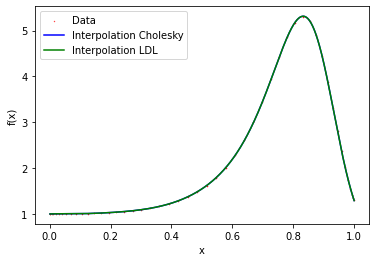

In [24]:
N_data   = 100
N_interp = 10
N_plot   = 1000
x_plot   = np.linspace(1,N_plot,N_plot)/N_plot

x_data = 0.5 * (1 + np.cos(pi*(2*np.array(range(N_data))-1)/N_data))
b      = np.array([np.exp(np.cos(y) - np.cos(5.*y/(2-y)**2)) for y in x_data])

A = np.array([[ y**i for i in range(N_interp)] for y in x_data])
V_Cholesky = LQ_Cholesky(A,np.log(b))
V_LDL = LQ_LDL(A,np.log(b))


plt.figure(1)
plt.scatter(x_data, b, color='red',  label="Data", marker='.', s=0.5)
plt.plot(x_plot, f(x_plot,V_Cholesky), color='blue', label='Interpolation Cholesky')
plt.plot(x_plot, f(x_plot,V_LDL), color='green', label='Interpolation LDL')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()